In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
HOME_PATH = "./gdrive/MyDrive/magisterka/"

In [ ]:
%%capture
!pip install pickle5

In [ ]:
import matplotlib.pyplot as plt
import pickle5 as pickle
import pandas as pd
import numpy as np


Do topic modeling oraz klasteryzacji uzywa sie wszystkich danych, a odsianych tylko przy obliczaniu metryk

 

# 1. Read data

In [ ]:
def read_annotations_df():
  df_anno_train = pd.read_pickle(HOME_PATH + f"df_anno_train.pkl")
  df_anno_dev = pd.read_pickle(HOME_PATH + f"df_anno_dev.pkl")
  df_anno_test = pd.read_pickle(HOME_PATH + f"df_anno_test.pkl")
  return df_anno_train, df_anno_dev, df_anno_test

def read_comments_dfs(min_topic_size=10):
  df_comments_train = pd.read_pickle(HOME_PATH + f"df_comments_train_mts{min_topic_size}.pkl")
  df_comments_dev = pd.read_pickle(HOME_PATH + f"df_comments_dev_mts{min_topic_size}.pkl")
  df_comments_test = pd.read_pickle(HOME_PATH + f"df_comments_test_mts{min_topic_size}.pkl")
  return df_comments_train, df_comments_dev, df_comments_test

def read_dfs(min_topic_size=10):
  return (*read_annotations_df(), *read_comments_dfs(min_topic_size))


df_anno_train, df_anno_dev, df_anno_test,\
df_comments_train, df_comments_dev, df_comments_test  = read_dfs()

df_annotations = pd.read_csv("./gdrive/MyDrive/magisterka/aggression_annotations.tsv", sep="\t")


In [ ]:
from collections import Counter
from tqdm import tqdm


def topic_to_matrix(matrix, topics):
    topics_counter = Counter(topics)
    topics = list(set(topics))

    for index, topic_x in enumerate(topics[:-1]):
      for topic_y in topics[(index + 1):]:
        sum = topics_counter[topic_x] + topics_counter[topic_y]
        matrix[topic_x][topic_y] += sum
        matrix[topic_y][topic_x] += sum

def get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, 
                           variant="micro",
                           dist_matrix=True):
  df_comments = pd.concat([df_comments_train, df_comments_dev]) # 92686
  df_annotations_train = df_annotations.merge(df_comments, on="rev_id")

  unique_worker_ids = set(df_annotations_train["worker_id"])

  n_topics = max(df_comments_train['topic'].to_list()) + 1
  all_topics_co_occurrence = np.eye(n_topics)
  hated_topics_co_occurrence = np.eye(n_topics)
  topic_correlation_matrix = np.eye(n_topics)
  
  for worker in tqdm(list(unique_worker_ids)):
    all_topics = df_annotations_train.loc[df_annotations_train["worker_id"] == worker, "topic"]
    all_topics = all_topics.to_list()
    topic_to_matrix(all_topics_co_occurrence, all_topics)

    hated_topics = df_annotations_train.loc[(df_annotations_train["worker_id"] == worker) & (df_annotations_train["aggression"] == 1.0), "topic"]
    hated_topics = hated_topics.to_list()
    topic_to_matrix(hated_topics_co_occurrence, hated_topics)

    if variant == "macro":
      user_probs = np.divide(hated_topics_co_occurrence, all_topics_co_occurrence,
                    out=np.zeros_like(hated_topics_co_occurrence),
                    where = all_topics_co_occurrence != 0)
      topic_correlation_matrix += user_probs

      hated_topics_co_occurrence = np.eye(n_topics)
      all_topics_co_occurrence = np.eye(n_topics)

  if variant == "macro":
    topic_correlation_matrix /= len(unique_worker_ids)
  else:
    topic_correlation_matrix = np.divide(hated_topics_co_occurrence, all_topics_co_occurrence,
                    out = np.zeros_like(hated_topics_co_occurrence),
                    where = all_topics_co_occurrence != 0)
  
  if dist_matrix:
    topic_correlation_matrix = 1 - np.abs(topic_correlation_matrix)
    np.fill_diagonal(topic_correlation_matrix, 0)
  else:
    np.fill_diagonal(topic_correlation_matrix, 1)
  assert (topic_correlation_matrix == topic_correlation_matrix.T).all()
  assert (topic_correlation_matrix > 1.0).sum() == 0
  
  return topic_correlation_matrix                  


In [ ]:
from os.path import exists

min_topic_size = 10

if exists(HOME_PATH + f"topic_corr_matrix_micro{min_topic_size}.npy"):
  topic_correlation_matrix_macro = np.load(HOME_PATH + f"topic_corr_matrix_macro{min_topic_size}.npy")
  topic_correlation_matrix_micro = np.load(HOME_PATH + f"topic_corr_matrix_micro{min_topic_size}.npy")
else:
  topic_correlation_matrix_macro = get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, "macro")
  np.save(HOME_PATH + f"topic_corr_matrix_macro{min_topic_size}", topic_correlation_matrix_macro)

  topic_correlation_matrix_micro = get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, "micro")
  np.save(HOME_PATH + f"topic_corr_matrix_micro{min_topic_size}", topic_correlation_matrix_micro)


In [ ]:
topic_correlation_matrix_micro

array([[0.        , 0.95479946, 0.94293809, ..., 0.98578381, 0.95397253,
        0.97165633],
       [0.95479946, 0.        , 0.96052759, ..., 0.98860708, 0.96791799,
        0.98088456],
       [0.94293809, 0.96052759, 0.        , ..., 0.984147  , 0.95394341,
        0.98094748],
       ...,
       [0.98578381, 0.98860708, 0.984147  , ..., 0.        , 0.97508651,
        0.99145299],
       [0.95397253, 0.96791799, 0.95394341, ..., 0.97508651, 0.        ,
        0.96817248],
       [0.97165633, 0.98088456, 0.98094748, ..., 0.99145299, 0.96817248,
        0.        ]])

In [ ]:
topic_correlation_matrix_macro

array([[0.        , 0.96517439, 0.95673362, ..., 0.9949454 , 0.9819454 ,
        0.99526295],
       [0.96517439, 0.        , 0.97045216, ..., 0.99654506, 0.98580886,
        0.99705574],
       [0.95673362, 0.97045216, 0.        , ..., 0.99624898, 0.98222631,
        0.99712731],
       ...,
       [0.9949454 , 0.99654506, 0.99624898, ..., 0.        , 0.99685597,
        0.99958848],
       [0.9819454 , 0.98580886, 0.98222631, ..., 0.99685597, 0.        ,
        0.997806  ],
       [0.99526295, 0.99705574, 0.99712731, ..., 0.99958848, 0.997806  ,
        0.        ]])

# 2. Clustering

## Elbow method (WSS)

In [ ]:
from sklearn.cluster import KMeans
from tqdm import tqdm

100%|██████████| 25/25 [00:39<00:00,  1.56s/it]


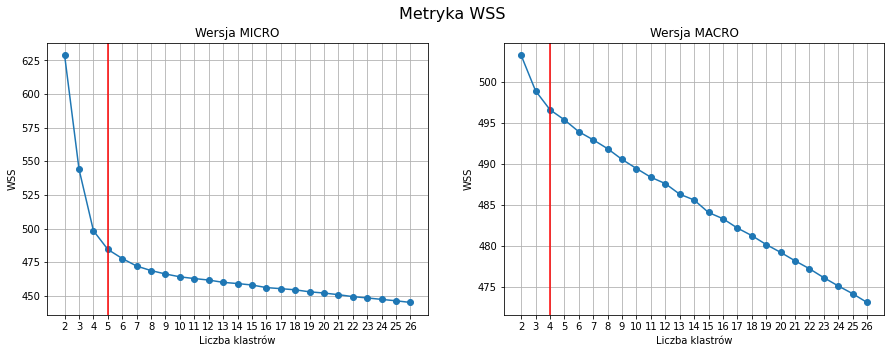

In [ ]:
# elbow method -> Within-Cluster-Sum of Squared Errors

def wss(*X, result_lines, max_k=26):
  fig, ax = plt.subplots(1,2, figsize=(15, 5))

  for i, x in enumerate(X):
    wss_results = []
    for k in tqdm(range(2, max_k+1)):
      kmeans = KMeans(n_clusters=k, n_init=30, random_state=0).fit(x)
      wss_results.append(kmeans.inertia_)

    ax[i].set_xlabel("Liczba klastrów")
    ax[i].set_ylabel("WSS")
    ax[i].plot(range(2, max_k+1), wss_results, linestyle='-', marker='o')
    ax[i].axvline(result_lines[i], color='r')
    ax[i].set_xticks(range(2, max_k+1, 1))
    ax[i].grid()

  ax[0].set_title("Wersja MICRO")
  ax[1].set_title("Wersja MACRO")
  fig.suptitle('Metryka WSS', fontsize=16)


  fig.show()

wss(topic_correlation_matrix_micro, topic_correlation_matrix_macro, result_lines=[5, 4], max_k=26)

100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


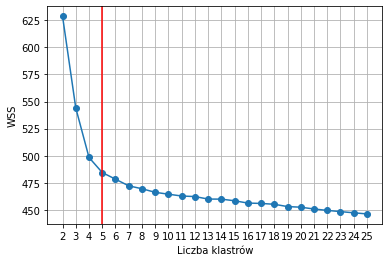

In [ ]:
# elbow method -> Within-Cluster-Sum of Squared Errors

def wss(X, max_k=25, result_line=5):
  wss_results = []
  for k in tqdm(range(2, max_k+1)):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X)
    wss_results.append(kmeans.inertia_)

  plt.plot(range(2, max_k+1), wss_results, linestyle='-', marker='o')
  plt.axvline(result_line, color='r')

  plt.xlabel('Liczba klastrów')
  plt.ylabel('WSS')
  plt.xticks(range(2, max_k+1, 1))
  plt.grid()


  plt.show()

wss(topic_correlation_matrix_micro)

100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


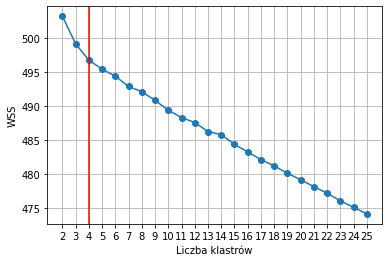

In [ ]:
wss(topic_correlation_matrix_macro, result_line=4)

## Gap statistic


In [ ]:
%%capture
!pip install --upgrade gap-stat

Optimal clusters:  13


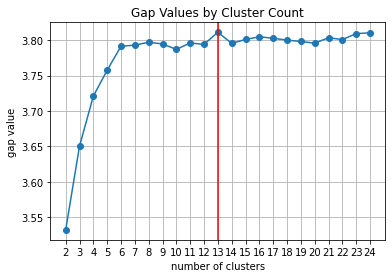

In [ ]:
from gap_statistic import OptimalK

# gap statistic - difference in compactness between clustering on reference data and original data 

def gap_stat(topic_correlation_matrix):
  optimalK = OptimalK(n_jobs=1, parallel_backend='joblib')
  n_clusters = optimalK(topic_correlation_matrix, cluster_array=np.arange(2, 25))
  print('Optimal clusters: ', n_clusters)

  plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linestyle='-',
          marker='o')
  plt.axvline(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters.to_list()[0]
              ,color='r')
  plt.grid(True)
  plt.xticks(range(2, 25, 1))
  plt.xlabel('number of clusters')
  plt.ylabel('gap value')
  plt.title('Gap Values by Cluster Count')
  plt.show()
  
  # optimalK.gap_df.head()

gap_stat(topic_correlation_matrix_micro)

Optimal clusters:  6


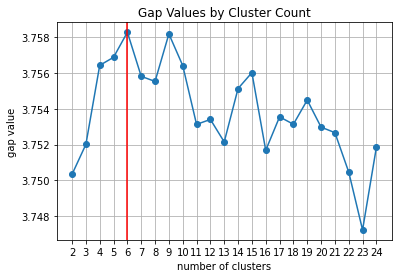

In [ ]:
gap_stat(topic_correlation_matrix_macro)

Text(0.5, 0.98, 'Metryka Gap-statistics')

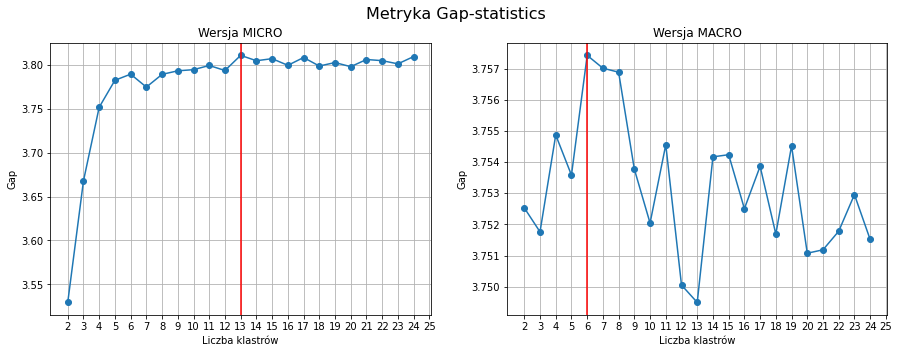

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

def get_clusters(x):
    optimalK = OptimalK(n_jobs=1, parallel_backend='joblib')
    n_clusters = optimalK(x, cluster_array=np.arange(2, 25))
    return optimalK, n_clusters

i = 0
for x, res in zip([topic_correlation_matrix_micro, topic_correlation_matrix_macro], [13, 6]):
    optimalK, n_clusters = get_clusters(x)
    while n_clusters != res:
      
      optimalK, n_clusters = get_clusters(x)
    ax[i].set_xlabel("Liczba klastrów")
    ax[i].set_ylabel("Gap")
    ax[i].plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linestyle='-', marker='o')
    ax[i].axvline(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters.to_list()[0], color='r')
    ax[i].set_xticks(range(2, 26, 1))
    ax[i].grid()
    i += 1

ax[0].set_title("Wersja MICRO")
ax[1].set_title("Wersja MACRO")
fig.suptitle('Metryka Gap-statistics', fontsize=16)

## Silhouette Coefficient


100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


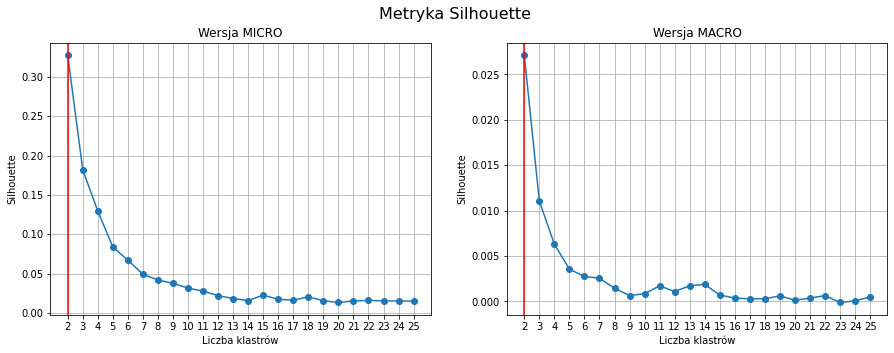

In [ ]:
from sklearn.metrics import silhouette_score


def plot_cluster_metric(metric_func, *X, name, max_k=25):
  fig, ax = plt.subplots(1,2, figsize=(15, 5))

  for i, x in enumerate(X):
    results = []
    for k in tqdm(range(2, max_k+1)):
      km = KMeans(n_clusters=k, n_init=30, random_state=0).fit(x)
      metric = metric_func(x, km.labels_)
      results.append(metric)

    ax[i].set_xlabel("Liczba klastrów")
    ax[i].set_ylabel(name)
    ax[i].plot(range(2, max_k+1), results, linestyle='-', marker='o')
    ax[i].axvline(2, color='r')
    ax[i].set_xticks(range(2, max_k+1, 1))
    ax[i].grid()


  ax[0].set_title("Wersja MICRO")
  ax[1].set_title("Wersja MACRO")
  fig.suptitle(f'Metryka {name}', fontsize=16)
  fig.show()


plot_cluster_metric(silhouette_score, topic_correlation_matrix_micro, topic_correlation_matrix_macro, name='Silhouette')


## Davies-Bouldin Index

100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


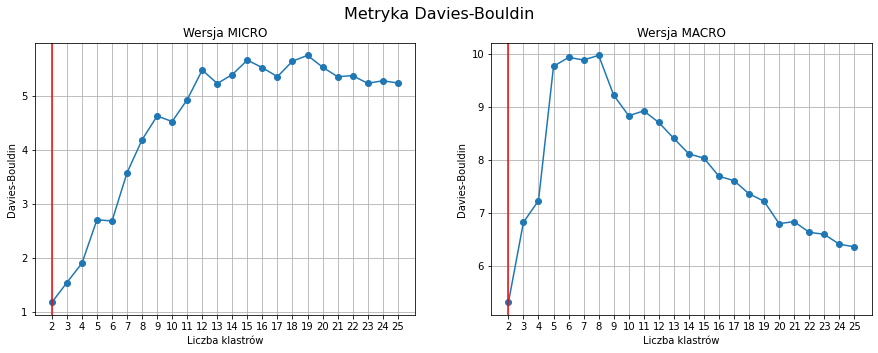

In [ ]:
from sklearn.metrics import davies_bouldin_score

# average similarity between each cluster and its most similar one
# similarity compactness / dist between centroid i and j

plot_cluster_metric(davies_bouldin_score, topic_correlation_matrix_micro, topic_correlation_matrix_macro, name='Davies-Bouldin', line_macro)


100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


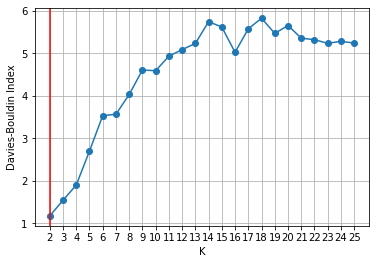

In [ ]:
from sklearn.metrics import davies_bouldin_score



plt, _, _ = plot_cluster_metric(davies_bouldin_score, topic_correlation_matrix_micro, 'Davies-Bouldin Index')
plt.axvline(2, color='r')
plt.show()


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


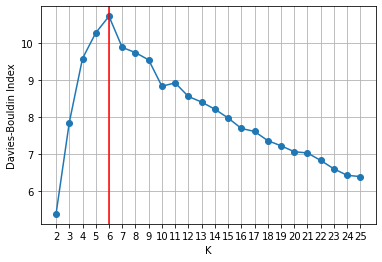

In [ ]:
plt, _, _ = plot_cluster_metric(davies_bouldin_score, topic_correlation_matrix_macro, 'Davies-Bouldin Index')
plt.axvline(6, color='r')
plt.show()

## Calinski-Harabasz Index

100%|██████████| 24/24 [00:29<00:00,  1.23s/it]


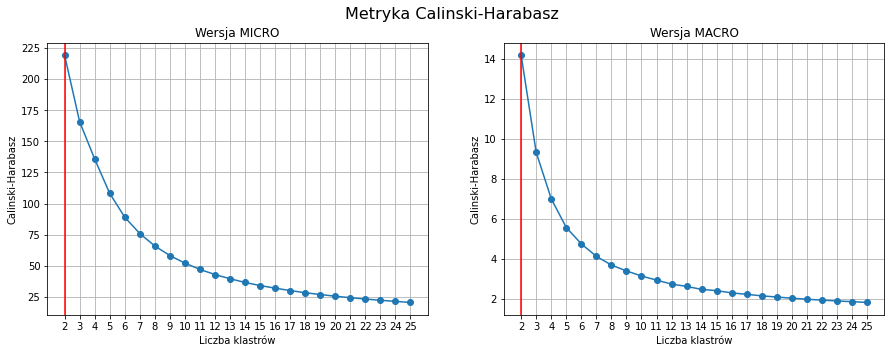

In [ ]:
from sklearn.metrics import calinski_harabasz_score

plot_cluster_metric(calinski_harabasz_score, topic_correlation_matrix_micro, topic_correlation_matrix_macro, name='Calinski-Harabasz')

100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


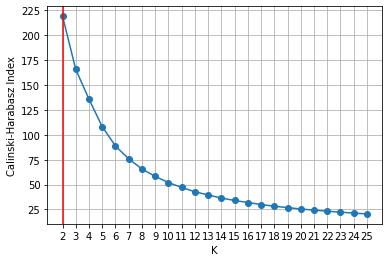

In [ ]:
from sklearn.metrics import calinski_harabasz_score

'''
The Calinski-Harabasz Index is based on the idea that clusters that are 
(1) themselves very compact and (2) well-spaced from each other are good clusters. 
The index is calculated by dividing the variance of the sums of squares of the distances of individual objects
 to their cluster center by the sum of squares of the distance between the cluster centers
'''

plt, _, _ = plot_cluster_metric(calinski_harabasz_score, topic_correlation_matrix_micro, 'Calinski-Harabasz Index')
plt.axvline(2, color='r')
plt.show()

100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


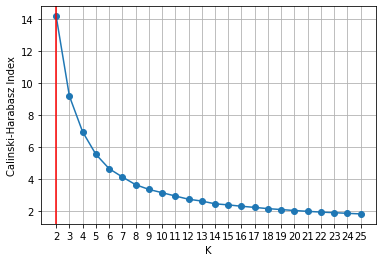

In [ ]:
plt, _, _ = plot_cluster_metric(calinski_harabasz_score, topic_correlation_matrix_macro, 'Calinski-Harabasz Index')
plt.axvline(2, color='r')
plt.show()

# 3. Different clustering methods


### k-means

In [ ]:
def get_labels(data, n_clusters, variant="micro"):
  if exists(HOME_PATH + f"cluster_labels_{variant}_{n_clusters}.npy"):
    labels = np.load(HOME_PATH + f"cluster_labels_{variant}_{n_clusters}.npy")
  else: 
    labels = KMeans(n_clusters = n_clusters, n_init=30, random_state=0).fit(data).labels_
    np.save(HOME_PATH + f"cluster_labels_{variant}_{n_clusters}", labels)
  return labels

labels_2_micro = get_labels(topic_correlation_matrix_micro, 2)
labels_5_micro = get_labels(topic_correlation_matrix_micro, 5)
labels_13_micro = get_labels(topic_correlation_matrix_micro, 13)


In [ ]:
labels_2_macro = get_labels(topic_correlation_matrix_macro, 2, "macro")
labels_4_macro = get_labels(topic_correlation_matrix_macro, 4, "macro")
labels_6_macro = get_labels(topic_correlation_matrix_macro, 6, "macro")

### HDBSCAN

In [ ]:
%%capture
!pip install hdbscan

In [ ]:
import hdbscan
from collections import Counter

def get_labels_hdbscan(data, min_cluster_size, variant="micro"):
  if False and exists(HOME_PATH + f"cluster_labels_hdbscan_{variant}.npy"):
    labels = np.load(HOME_PATH + f"cluster_labels_hdbscan_{variant}.npy")
  else:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size) # for: 3, 4 same results
    clusterer.fit(data)
    labels = clusterer.labels_
    np.save(HOME_PATH + f"cluster_labels_hdbscan_{variant}", labels)
  return labels

topic_correlation_matrix_micro = get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, variant="micro", dist_matrix=False)
topic_correlation_matrix_macro = get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, variant="macro", dist_matrix=False)

for min_cluster_size in [3, 4, 5, 7, 10]:
  labels_hdbscan_micro = get_labels_hdbscan(topic_correlation_matrix_micro, min_cluster_size, "micro")
  labels_hdbscan_macro = get_labels_hdbscan(topic_correlation_matrix_macro, min_cluster_size, "macro")
  print(f"min_cluster_size={min_cluster_size}, micro={Counter(labels_hdbscan_micro):} macro={Counter(labels_hdbscan_macro)}")


100%|██████████| 4050/4050 [02:24<00:00, 28.03it/s]


min_cluster_size=3, micro=Counter({0: 496, -1: 7, 1: 6}) macro=Counter({-1: 509})
min_cluster_size=4, micro=Counter({0: 495, -1: 9, 1: 5}) macro=Counter({-1: 509})
min_cluster_size=5, micro=Counter({0: 495, 1: 9, -1: 5}) macro=Counter({-1: 509})
min_cluster_size=7, micro=Counter({0: 492, 1: 9, -1: 8}) macro=Counter({-1: 509})
min_cluster_size=10, micro=Counter({-1: 509}) macro=Counter({-1: 509})


### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

def get_labels_dbscan(data, eps, variant="micro"):
  if exists(HOME_PATH + f"cluster_labels_dbscan_{variant}.npy"):
    labels = np.load(HOME_PATH + f"cluster_labels_dbscan_{variant}.npy")
  else:
    clusterer = DBSCAN(min_samples=2, eps=eps).fit(data)
    labels = clusterer.labels_
    np.save(HOME_PATH + f"cluster_labels_dbscan_{variant}", labels)
  return labels

topic_correlation_matrix_micro_dbscan = get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, variant="micro", dist_matrix=False)
topic_correlation_matrix_macro_dbscan = get_correlation_matrix(df_comments_train, df_comments_dev, df_annotations, variant="macro", dist_matrix=False)

for eps in [0.5, 1, 10, 50, 100, 500]:
  labels_dbscan_micro = get_labels_dbscan(topic_correlation_matrix_micro_dbscan, eps, "micro")
  labels_dbscan_macro = get_labels_dbscan(topic_correlation_matrix_macro_dbscan, eps, "macro")
  print(f"epsilon={eps}, micro={Counter(labels_dbscan_micro):} macro={Counter(labels_dbscan_macro)}")


100%|██████████| 4050/4050 [02:26<00:00, 27.61it/s]


epsilon=0.5, micro=Counter({-1: 509}) macro=Counter({-1: 509})
epsilon=1, micro=Counter({-1: 509}) macro=Counter({-1: 509})
epsilon=10, micro=Counter({-1: 509}) macro=Counter({-1: 509})
epsilon=50, micro=Counter({-1: 509}) macro=Counter({-1: 509})
epsilon=100, micro=Counter({-1: 509}) macro=Counter({-1: 509})
epsilon=500, micro=Counter({-1: 509}) macro=Counter({-1: 509})


# 4. Plots

In [ ]:
import seaborn as sns

def topics_to_clusters(df, labels, n_clusters):
  index_to_clusters = []
  df_orginal = df.copy()
  for cluster in range(-1, n_clusters):
    indexes = np.where(labels == cluster)[0]
    df.loc[df_orginal["topic"].isin(list(indexes)), ["topic"]] = cluster
  return df


def plot_and_save_df(labels, n_clusters, variant, ylim=100, polish=False, algorithm=""):
  df_annotations = pd.read_pickle("./gdrive/MyDrive/magisterka/df_annotations_to_use.pkl")
  df_comments_train, df_comments_dev, df_comments_test = read_dfs()[3:]

  for df, name in zip([df_comments_train, df_comments_dev, df_comments_test],
                      ["train", "dev", "test"]):
    df = topics_to_clusters(df, labels, n_clusters)
    df.to_pickle(f"{HOME_PATH}df-comments-clusters-{algorithm}-{variant}-{n_clusters}-{name}.pkl")


  all_df = pd.concat([df_comments_train, df_comments_dev, df_comments_test])
  print(all_df["topic"].value_counts())

  df_all_annotations = pd.merge(df_annotations, all_df, on="rev_id")
  df_hate = df_all_annotations.loc[df_all_annotations["aggression"] == 1.0]
  print(df_hate["topic"].value_counts())

  fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

  sns.histplot(data=all_df, x="topic", discrete=True, stat="percent", ax=axs[0])
  axs[0].set_xticks(range(n_clusters))
  axs[0].set_title(f"Topic distribution in all comments - {algorithm}")
  axs[0].set_ylim(0, ylim)


  sns.histplot(data=df_hate, x="topic", discrete=True, stat="percent", ax=axs[1])
  axs[1].set_xticks(range(n_clusters))
  axs[1].set_title(f"Topic distribution in hate comments - {algorithm}")
  axs[1].set_ylim(0, ylim)

  if algorithm == "hdbscan":
    axs[0].set_xlim(-2, 2)
    axs[1].set_xlim(-2, 2)
    axs[0].set_xticks(range(-1, n_clusters))
    axs[1].set_xticks(range(-1, n_clusters))

  if polish:
    axs[0].set_title("Rozkład wszystkich komentarzy wśród klastrów")
    axs[1].set_title("Rozkład agresywnych komentarzy wśród klastrów")
    axs[0].set_ylabel("Procent")
    axs[1].set_ylabel("Procent")
    axs[0].set_xlabel("Klastra")
    axs[1].set_xlabel("Klaster")


 0    114828
 1       583
-1       453
Name: topic, dtype: int64
 0    220316
-1       170
 1        81
Name: topic, dtype: int64


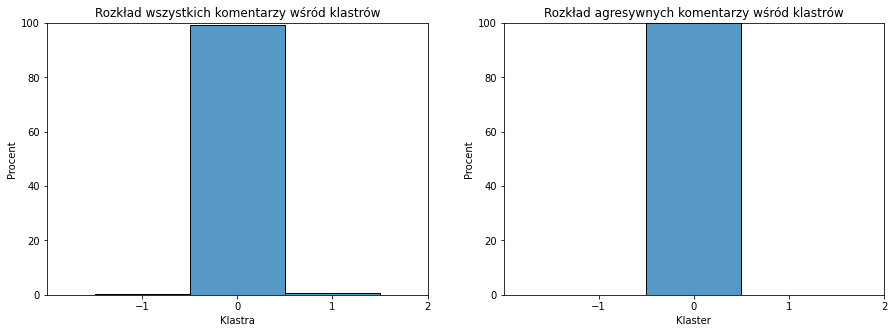

In [ ]:
plot_and_save_df(labels_hdbscan_micro, 3, "micro", polish=True, algorithm="hdbscan")

2
5
13


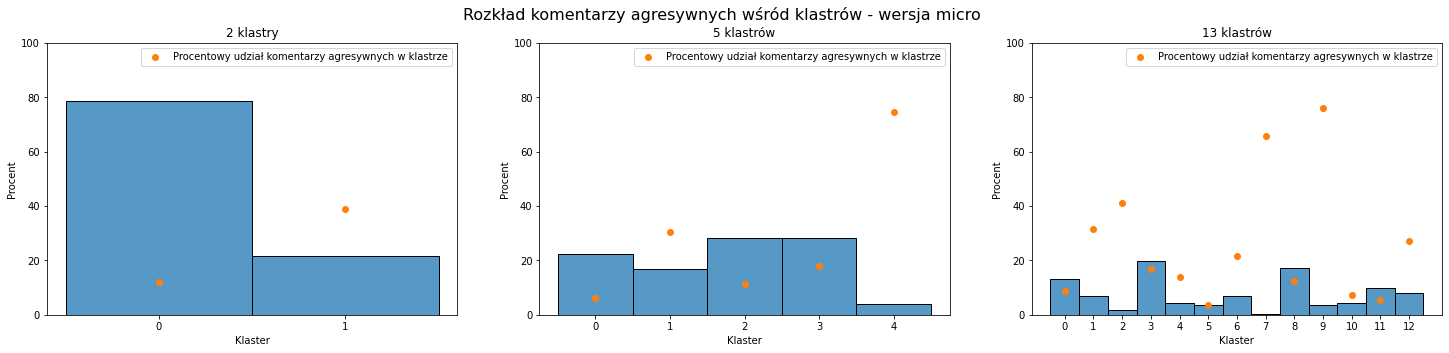

In [ ]:
import matplotlib.patches as mpatches

### TESTING WITH DOTS

def plot_test(ax, labels, n_clusters, variant, ylim=100):
  df_annotations = pd.read_pickle("./gdrive/MyDrive/magisterka/df_annotations_to_use.pkl")
  df_comments_train, df_comments_dev, df_comments_test = read_dfs()[3:]

  for df, name in zip([df_comments_train, df_comments_dev, df_comments_test],
                      ["train", "dev", "test"]):
    df = topics_to_clusters(df, labels, n_clusters)
  
  all_df = pd.concat([df_comments_train, df_comments_dev, df_comments_test])
  df_all_annotations = pd.merge(df_annotations, all_df, on="rev_id")
  points = df_all_annotations.groupby(['topic'])['aggression'].mean().agg({'list':lambda x: list(x)})['list']

  df_hate = df_all_annotations.loc[df_all_annotations["aggression"] == 1.0]
  sns.histplot(data=df_all_annotations, x="topic", discrete=True, stat="percent", ax=ax)
  # sns.histplot(data=df_hate, x="topic", discrete=True, stat="percent", ax=ax, color="r")

  ax.set_xticks(range(n_clusters))
  ax.set_ylim(0, ylim)
  points = [100 * p for p in points]

  ax.scatter(list(range(n_clusters)), points, zorder=100, label='Procentowy udział komentarzy agresywnych w klastrze')
  # orange_dots = mpatches.Patch(color='orange', label='Procentowy udział komentarzy agresywnych w klastrze')
  # plt.legend(handles=[orange_dots], loc='upper left')
  ax.legend()
  if n_clusters == 2:
    ax.set_title(f"{n_clusters} klastry")
  else:
    ax.set_title(f"{n_clusters} klastrów")
  ax.set_ylabel("Procent")
  ax.set_xlabel("Klaster")



def plot_dist_test(labels, ks, variant):
  fig, axs = plt.subplots(ncols=3, figsize=(25, 5))
  for k, label, ax in zip(ks, labels, axs):
    plot_test(ax, label, k, variant)
    
  fig.suptitle(f'Rozkład komentarzy agresywnych wśród klastrów - wersja {variant}', fontsize=16)

plot_dist_test([labels_2_micro, labels_5_micro, labels_13_micro], [2, 5, 13], "micro")



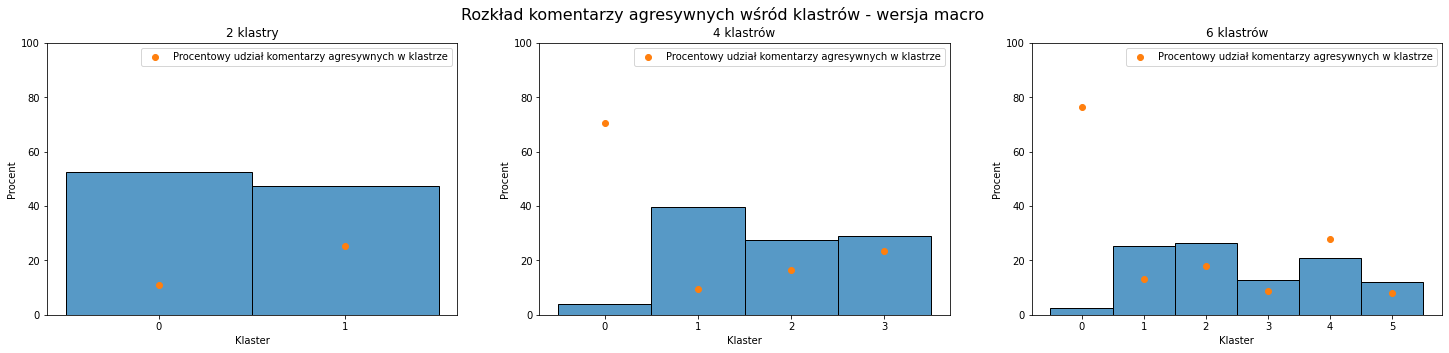

In [ ]:
### TESTING WITH DOTS 2
plot_dist_test([labels_2_macro, labels_4_macro, labels_6_macro], [2, 4, 6], "macro")

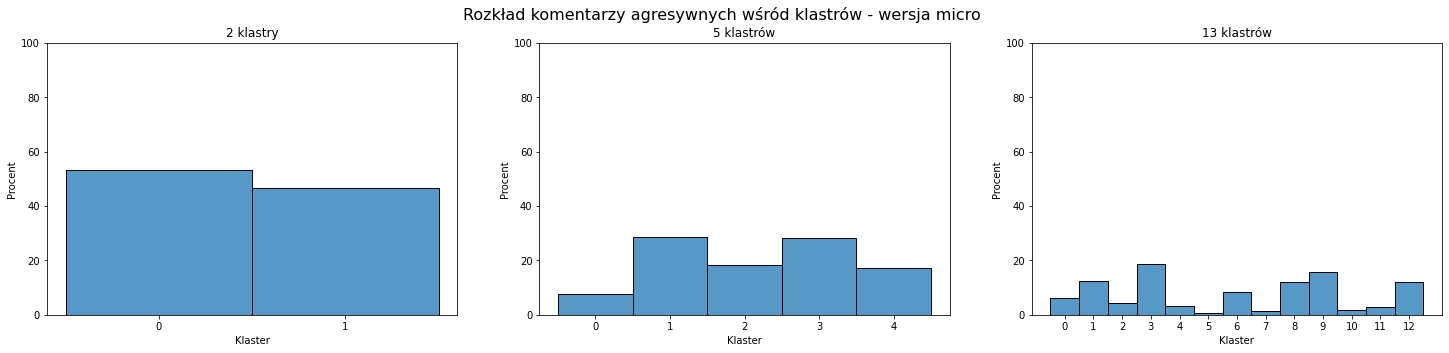

In [ ]:

def plot_1(ax, labels, n_clusters, variant, ylim=100):
  df_annotations = pd.read_pickle("./gdrive/MyDrive/magisterka/df_annotations_to_use.pkl")
  df_comments_train, df_comments_dev, df_comments_test = read_dfs()[3:]

  for df, name in zip([df_comments_train, df_comments_dev, df_comments_test],
                      ["train", "dev", "test"]):
    df = topics_to_clusters(df, labels, n_clusters)
    
  all_df = pd.concat([df_comments_train, df_comments_dev, df_comments_test])
  df_all_annotations = pd.merge(df_annotations, all_df, on="rev_id")
  df_hate = df_all_annotations.loc[df_all_annotations["aggression"] == 1.0]
  sns.histplot(data=df_hate, x="topic", discrete=True, stat="percent", ax=ax)
  ax.set_xticks(range(n_clusters))
  ax.set_ylim(0, ylim)

  if n_clusters == 2:
    ax.set_title(f"{n_clusters} klastry")
  else:
    ax.set_title(f"{n_clusters} klastrów")
  ax.set_ylabel("Procent")
  ax.set_xlabel("Klaster")



def plot_dist(labels, ks, variant):
  fig, axs = plt.subplots(ncols=3, figsize=(25, 5))
  for k, label, ax in zip(ks, labels, axs):
    plot_1(ax, label, k, variant)
  fig.suptitle(f'Rozkład komentarzy agresywnych wśród klastrów - wersja {variant}', fontsize=16)

plot_dist([labels_2_micro, labels_5_micro, labels_13_micro], [2, 5, 13], "micro")

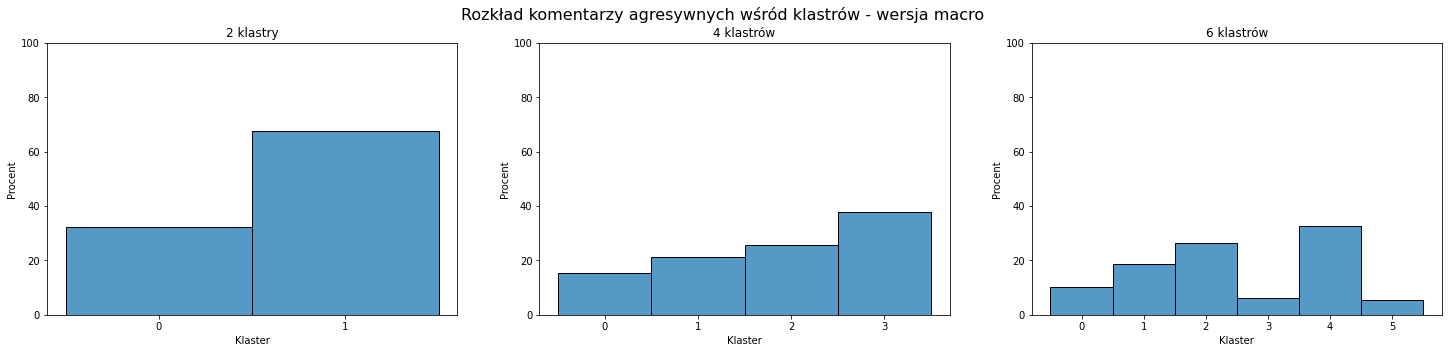

In [ ]:
plot_dist([labels_2_macro, labels_4_macro, labels_6_macro], [2, 4, 6], "macro")

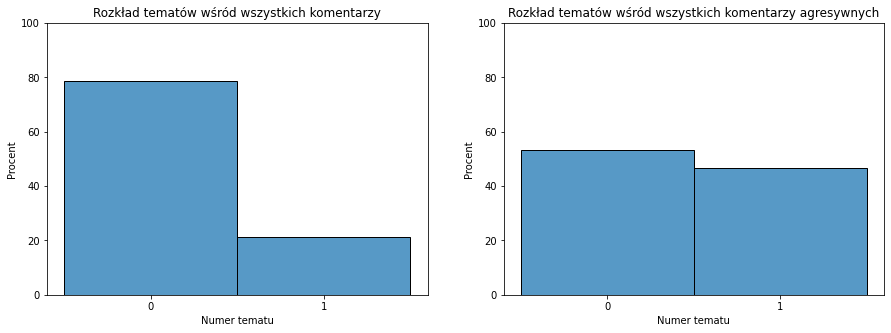

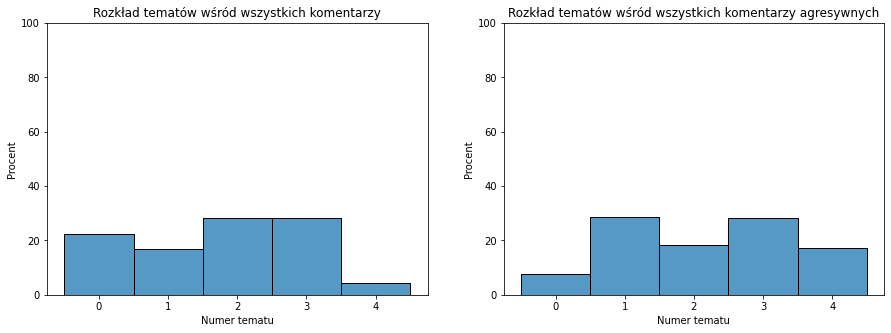

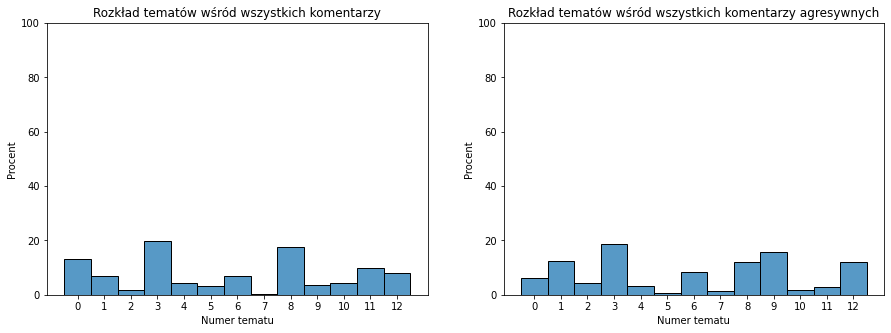

In [ ]:
plot_and_save_df(labels_2_micro, 2, "micro", polish=True)
plot_and_save_df(labels_5_micro, 5, "micro", polish=True)
plot_and_save_df(labels_13_micro, 13, "micro", polish=True)

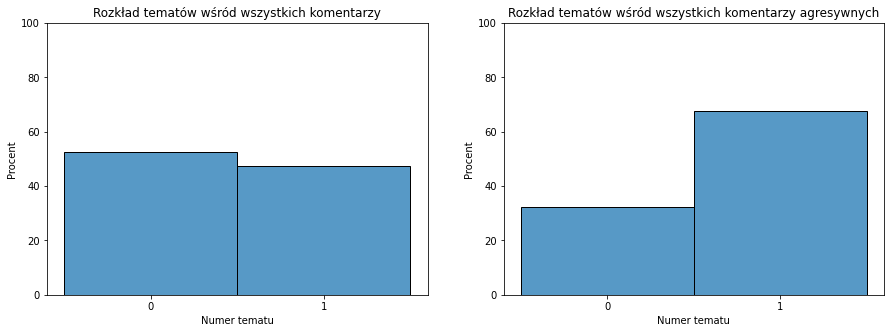

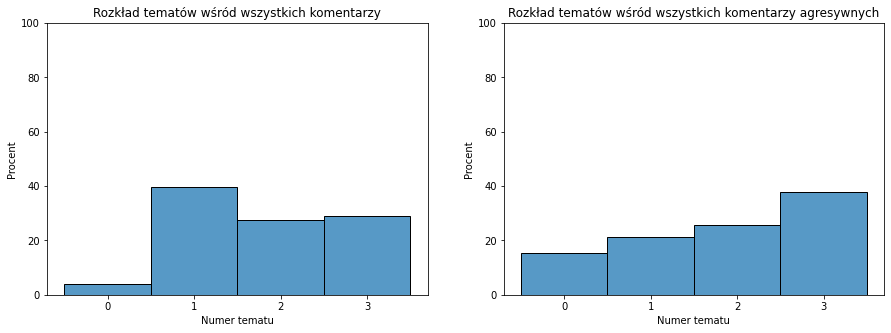

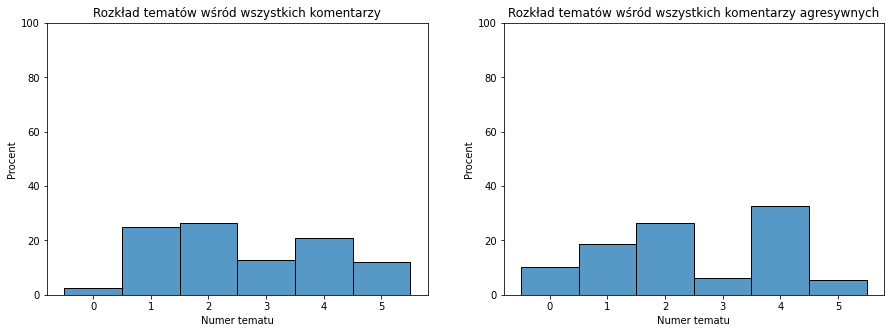

In [ ]:
plot_and_save_df(labels_2_macro, 2, "macro", polish=True)
plot_and_save_df(labels_4_macro, 4, "macro", polish=True)
plot_and_save_df(labels_6_macro, 6, "macro", polish=True)

In [ ]:
import seaborn as sns

def get_annotations_per_topic(n_clusters, ylim, variant):
  df_annotations = pd.read_pickle("./gdrive/MyDrive/magisterka/df_annotations_to_use.pkl")

  df_comments_train = pd.read_pickle(f"{HOME_PATH}df-comments-clusters-{variant}-{n_clusters}-train.pkl")
  df_comments_dev = pd.read_pickle(f"{HOME_PATH}df-comments-clusters-{variant}-{n_clusters}-dev.pkl")
  df_comments_train_dev = pd.concat([df_comments_train, df_comments_dev])
  
  fig, axs = plt.subplots(ncols=2, figsize=(10, 8))
  fig.suptitle("Number of all annotations by single user per topic", fontsize=14)

  def plot(i, title, df_comments):
    df_anno_comm = pd.merge(df_annotations, df_comments, on="rev_id")
    workers_stats = df_anno_comm.groupby(['worker_id', 'topic'])['rev_id'].count().reset_index()
    sns.boxplot(x=workers_stats["topic"], y=workers_stats["rev_id"], ax=axs[i])\
    .set(title=title, ylabel='Number of annotations by single user')
    axs[i].set_ylim(0, ylim)

    median_df = workers_stats.groupby(['topic'])['rev_id'].median().reset_index()
    median_df = median_df.rename(columns={"rev_id": "median"})
    print(f"{title}:")
    print(median_df["median"])

  plot(0, "DEV", df_comments_dev)
  plot(1, "TRAIN + DEV", df_comments_train_dev)


DEV:
0    59.0
1    19.0
Name: median, dtype: float64
TRAIN + DEV:
0    240.0
1     78.0
Name: median, dtype: float64


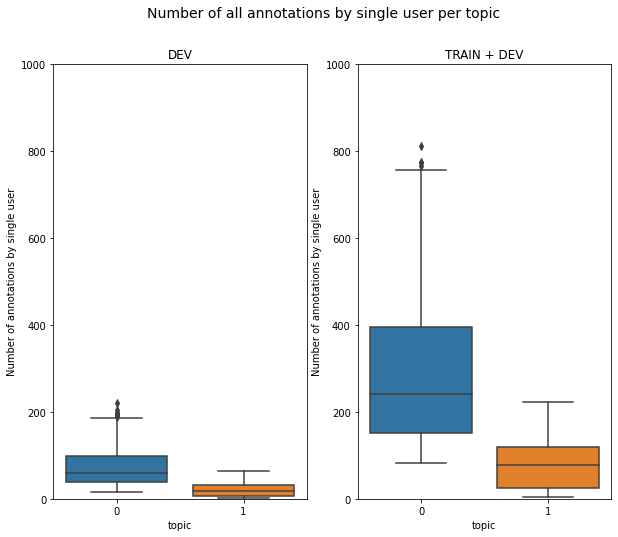

In [ ]:
get_annotations_per_topic(2, 1000, "micro")

DEV:
0    40.0
1    37.0
Name: median, dtype: float64
TRAIN + DEV:
0    161.0
1    150.0
Name: median, dtype: float64


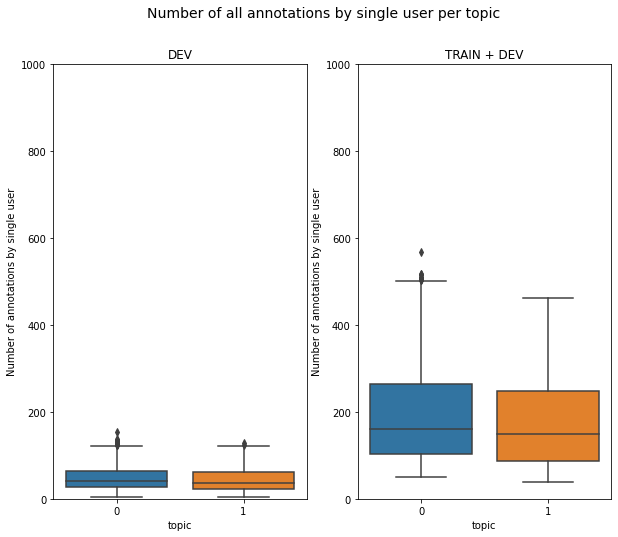

In [ ]:
get_annotations_per_topic(2, 1000, "macro")

DEV:
0    17.0
1    14.5
2    22.0
3    22.0
4     5.0
Name: median, dtype: float64
TRAIN + DEV:
0    70.0
1    60.0
2    87.0
3    87.0
4    17.0
Name: median, dtype: float64


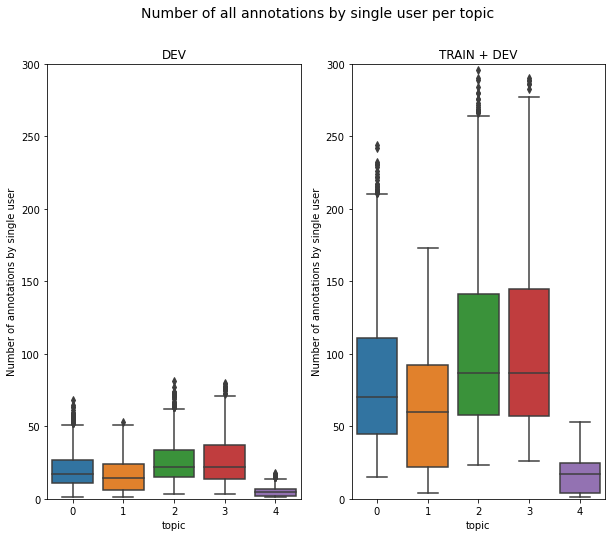

In [ ]:
get_annotations_per_topic(5, 300, "micro")

DEV:
0     4.0
1    30.0
2    21.0
3    23.0
Name: median, dtype: float64
TRAIN + DEV:
0     15.0
1    123.0
2     85.0
3     91.0
Name: median, dtype: float64


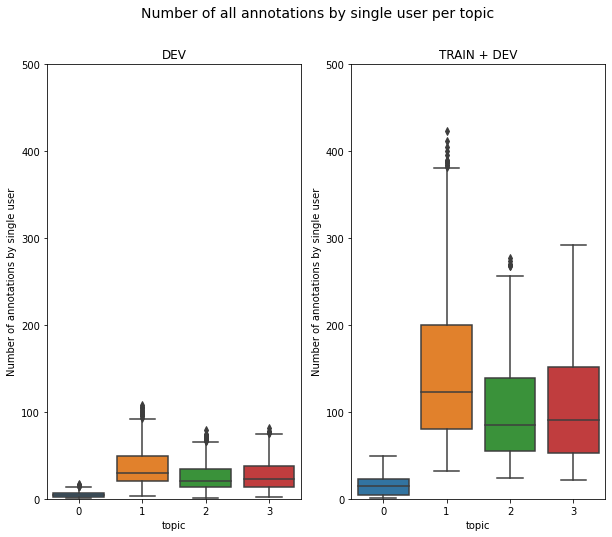

In [ ]:
get_annotations_per_topic(4, 500, "macro")

DEV:
0     10.0
1      6.0
2      2.0
3     15.0
4      3.0
5      3.0
6      6.0
7      1.0
8     13.0
9      4.0
10     4.0
11     8.0
12     7.0
Name: median, dtype: float64
TRAIN + DEV:
0     40.0
1     25.0
2      7.0
3     61.0
4     13.0
5     10.0
6     22.0
7      2.0
8     54.0
9     15.0
10    14.0
11    31.0
12    28.0
Name: median, dtype: float64


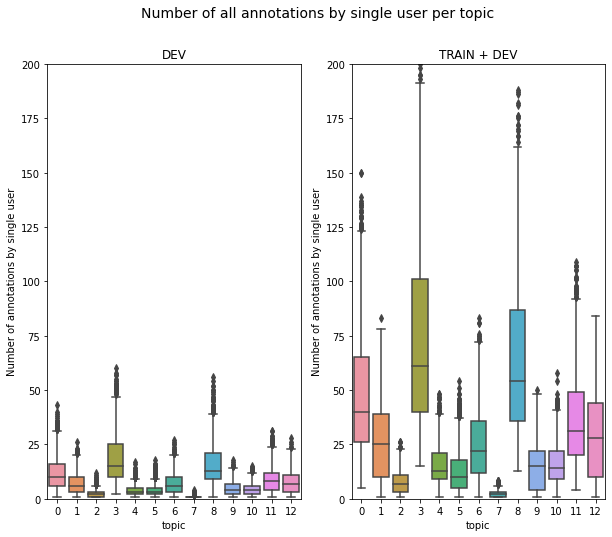

In [ ]:
get_annotations_per_topic(13, 200, "micro")

DEV:
0     3.0
1    19.0
2    20.0
3    10.0
4    17.0
5     9.0
Name: median, dtype: float64
TRAIN + DEV:
0    10.0
1    77.0
2    82.0
3    40.0
4    68.0
5    39.0
Name: median, dtype: float64


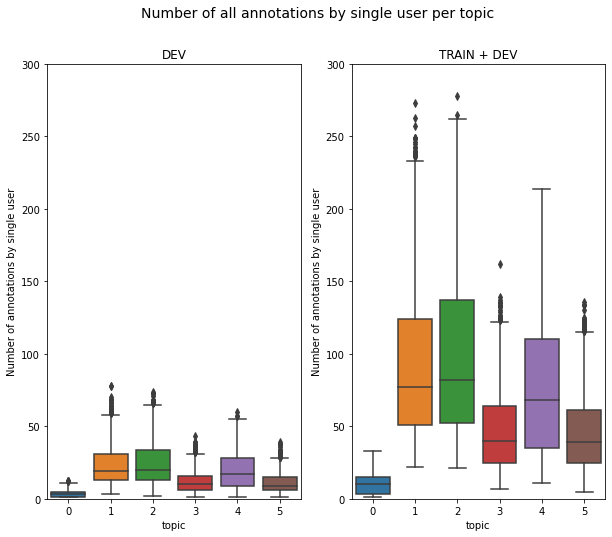

In [ ]:
get_annotations_per_topic(6, 300, "macro")